In [1]:
import sys
sys.executable

'K:\\Anaconda3\\envs\\efficientdet-pytorch\\python.exe'

In [2]:
import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob

In [3]:
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [4]:
marking = pd.read_csv('global-wheat-detection/train.csv')

bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    marking[column] = bboxs[:,i]
marking.drop(columns=['bbox'], inplace=True)

In [5]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df_folds = marking[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'source'] = marking[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

K:\Anaconda3\envs\efficientdet-pytorch\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [6]:
def get_train_transforms():
    return A.Compose(
        [
            #A.RandomSizedCrop(min_max_height=(512, 512), height=1024, width=1024, p=0.5),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1.0),
            A.Cutout(num_holes=4, max_h_size=64, max_w_size=64, fill_value=0, p=0.2),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

8000
2000


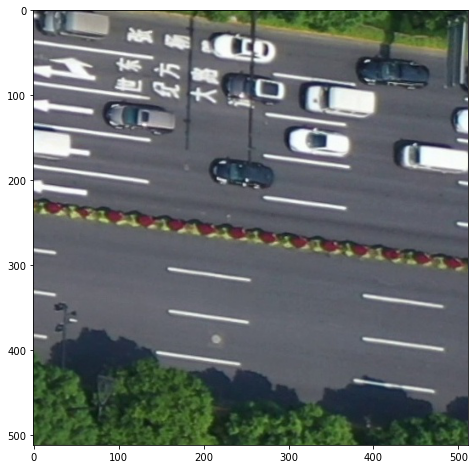

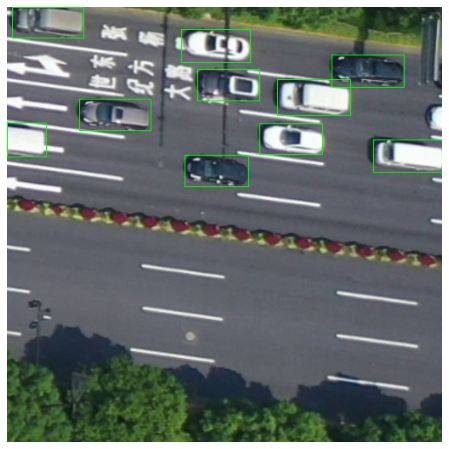

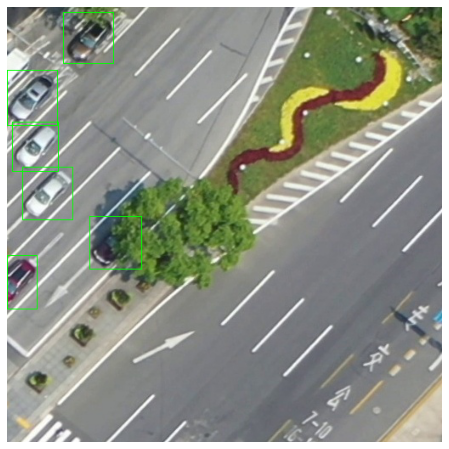

In [7]:
class DatasetRetriever(Dataset):
    def __init__(self, root, transform=None, test=False):
        super(DatasetRetriever, self).__init__()
        if isinstance(root, torch._six.string_classes):
            root = os.path.expanduser(root)
        self.root = root
        self.transform = transform
        data_path = os.path.join(root, "obj")
        if test:
            list_path = os.path.join(root, "test.txt")
        else:
            list_path = os.path.join(root, "train.txt")
        with open(list_path) as f1:
            lines = f1.readlines()
            lines = [line.replace("\n", "") for line in lines]
        self.img_ids = list(range(len(lines)))
        self.img_names = list(lines)

    def __getitem__(self, index):
        img_id = self.img_ids[index]
        path = os.path.join(self.root,  self.img_names[index])
        image = cv2.imread(path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0        

        with open(path.replace(".jpg", ".txt")) as f:
            lines = f.readlines()
        boxes = []
        for line in lines:
            values = [float(token) for token in line.replace("\n", "").split(" ")]
            bbox = [(values[1]-values[3]*0.5)*512, (values[2]-values[4]*0.5)*512,
                    (values[1]+values[3]*0.5)*512, (values[2]+values[4]*0.5)*512]
            boxes.append(bbox)
            
        boxes = torch.tensor(boxes, dtype=torch.float32)
        boxes = torch.min(boxes, torch.tensor([512.0]))
        boxes = torch.max(boxes, torch.tensor([0.0]))
        
        # there is only one class
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])

        if self.transform:
            for i in range(10):
                sample = self.transform(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })

                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    #yxyx: be warning
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  
                    target['labels'] = torch.stack(sample['labels']) # <--- add this!
                    #print(target['boxes'].shape, target['labels'].shape)
                    #assert len(sample['bboxes']) == labels.shape[0], 'not equal!'
                    break

        return image, target, img_id

    def __len__(self):
        return len(self.img_ids)
        
    def get_img(self, index):
        img_id = self.img_ids[index]
        path = os.path.join(self.root,  self.img_names[index])
        image = cv2.imread(path, cv2.IMREAD_COLOR)
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

d = DatasetRetriever("drone")
print(len(d))
dd = DatasetRetriever("drone", test=True)
print(len(dd))
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.imshow(d.get_img(0))       
for i, (img, target, img_id) in enumerate(d):
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    for box in target["boxes"]:
        cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (0, 1, 0), 1)
    ax.set_axis_off()
    ax.imshow(img);
    if i == 1:
        break

In [8]:
train_dataset = DatasetRetriever("drone", transform=get_train_transforms(), test=False)
validation_dataset = DatasetRetriever("drone", transform=get_valid_transforms(), test=True)

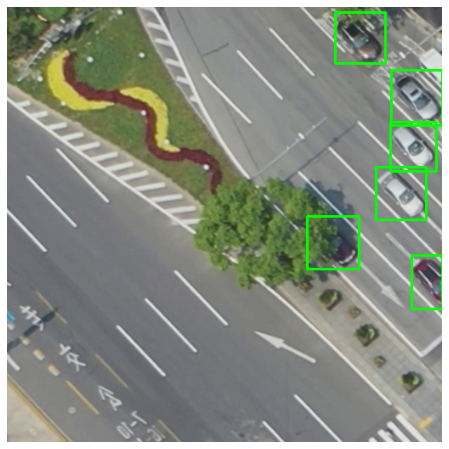

In [37]:
image, target, image_id = train_dataset[1]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image);

In [38]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [39]:
import warnings

warnings.filterwarnings("ignore")

class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                #for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                #    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                target_res = {}
                target_res['bbox'] = boxes
                target_res['cls'] = labels 
                target_res["img_scale"] = torch.tensor([1.0] * batch_size, dtype=torch.float).to(self.device)
                target_res["img_size"] = torch.tensor([images[0].shape[-2:]] * batch_size, dtype=torch.float).to(self.device)

                outputs = self.model(images, target_res)
                loss = outputs['loss']
                
                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            
            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]

            target_res = {}
            target_res['bbox'] = boxes
            target_res['cls'] = labels 
            target_res["img_scale"] = torch.tensor([1.0] * batch_size, dtype=torch.float).to(self.device)
            target_res["img_size"] = torch.tensor([images[0].shape[-2:]] * batch_size, dtype=torch.float).to(self.device)

            self.optimizer.zero_grad()
            
            outputs = self.model(images, target_res)
            loss = outputs['loss']
            
            loss.backward()

            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()

        return summary_loss
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [40]:
class TrainGlobalConfig:
    num_workers = 0
    batch_size = 8
    n_epochs = 32 # n_epochs = 40
    lr = 0.0002

    folder = 'effdet-d2-drone'

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss

#     SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
#     scheduler_params = dict(
#         max_lr=0.001,
#         epochs=n_epochs,
#         steps_per_epoch=int(len(train_dataset) / batch_size),
#         pct_start=0.1,
#         anneal_strategy='cos', 
#         final_div_factor=10**5
#     )
    
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=1,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )
    # --------------------

In [41]:
def collate_fn(batch):
    return tuple(zip(*batch))

def run_training():
    device = torch.device('cuda:0')
    net.to(device)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    fitter.fit(train_loader, val_loader)

In [42]:
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet

def get_net():
    config = get_efficientdet_config('tf_efficientdet_d2')
    net = EfficientDet(config, pretrained_backbone=False)
    checkpoint = torch.load('tf_efficientdet_d2.pth')
    net.load_state_dict(checkpoint)
    config.num_classes = 1
    config.image_size = 512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    return DetBenchTrain(net, config)

net = get_net()

In [258]:
run_training()  # 512, batch size 4, 3 epochs

Fitter prepared. Device is cuda:0

2020-10-07T14:12:03.854056
LR: 0.0002
[RESULT]: Train. Epoch: 0, summary_loss: 10.00302, time: 586.22970
[RESULT]: Val. Epoch: 0, summary_loss: 0.39712, time: 140.83741

2020-10-07T14:24:11.613300
LR: 0.0002
[RESULT]: Train. Epoch: 1, summary_loss: 0.26399, time: 538.78271
[RESULT]: Val. Epoch: 1, summary_loss: 0.16414, time: 140.99598

2020-10-07T14:35:32.084150
LR: 0.0002
[RESULT]: Train. Epoch: 2, summary_loss: 0.16770, time: 547.13726
[RESULT]: Val. Epoch: 2, summary_loss: 0.13117, time: 150.38258


In [85]:
run_training()  # 512, batch size 4, 3 epochs, no more random crop

Fitter prepared. Device is cuda:0

2020-10-08T11:28:57.333960
LR: 0.0002
[RESULT]: Train. Epoch: 0, summary_loss: 9.22773, time: 458.63592
[RESULT]: Val. Epoch: 0, summary_loss: 0.36883, time: 45.17571

2020-10-08T11:37:21.825770
LR: 0.0002
[RESULT]: Train. Epoch: 1, summary_loss: 0.23230, time: 432.10339
[RESULT]: Val. Epoch: 1, summary_loss: 0.15868, time: 35.85513

2020-10-08T11:45:10.487373
LR: 0.0002
[RESULT]: Train. Epoch: 2, summary_loss: 0.14589, time: 433.74470
[RESULT]: Val. Epoch: 2, summary_loss: 0.12073, time: 36.08451


In [108]:
run_training()  # 512 + 1024, batch size 8, 6 epochs

Fitter prepared. Device is cuda:0

2020-10-08T14:06:59.054828
LR: 0.0002
[RESULT]: Train. Epoch: 0, summary_loss: 9.98210, time: 900.01604
[RESULT]: Val. Epoch: 0, summary_loss: 0.40818, time: 86.58153

2020-10-08T14:23:26.458247
LR: 0.0002
[RESULT]: Train. Epoch: 1, summary_loss: 0.24788, time: 854.59098
[RESULT]: Val. Epoch: 1, summary_loss: 0.16683, time: 76.76872

2020-10-08T14:38:58.588893
LR: 0.0002
[RESULT]: Train. Epoch: 2, summary_loss: 0.15330, time: 851.17600
[RESULT]: Val. Epoch: 2, summary_loss: 0.12011, time: 77.83565

2020-10-08T14:54:28.405392
LR: 0.0002
[RESULT]: Train. Epoch: 3, summary_loss: 0.12132, time: 793.41155
[RESULT]: Val. Epoch: 3, summary_loss: 0.10387, time: 72.48219

2020-10-08T15:08:55.133893
LR: 0.0002
[RESULT]: Train. Epoch: 4, summary_loss: 0.10652, time: 817.98878
[RESULT]: Val. Epoch: 4, summary_loss: 0.08967, time: 63.96296

2020-10-08T15:23:37.812675
LR: 0.0002
[RESULT]: Train. Epoch: 5, summary_loss: 0.09611, time: 690.84215
[RESULT]: Val. Epoch:

In [43]:
run_training()  # 512 + 1024, batch size 8, 32 epochs

Fitter prepared. Device is cuda:0

2020-10-08T16:12:51.946919
LR: 0.0002
[RESULT]: Train. Epoch: 0, summary_loss: 10.03913, time: 694.08898
[RESULT]: Val. Epoch: 0, summary_loss: 0.40585, time: 63.12022

2020-10-08T16:25:29.902161
LR: 0.0002
[RESULT]: Train. Epoch: 1, summary_loss: 0.25534, time: 727.40296
[RESULT]: Val. Epoch: 1, summary_loss: 0.16825, time: 79.21319

2020-10-08T16:38:57.238385
LR: 0.0002
[RESULT]: Train. Epoch: 2, summary_loss: 0.15516, time: 722.49309
[RESULT]: Val. Epoch: 2, summary_loss: 0.12141, time: 62.86789

2020-10-08T16:52:03.341386
LR: 0.0002
[RESULT]: Train. Epoch: 3, summary_loss: 0.12569, time: 688.94596
[RESULT]: Val. Epoch: 3, summary_loss: 0.10196, time: 62.98558

2020-10-08T17:04:35.951096
LR: 0.0002
[RESULT]: Train. Epoch: 4, summary_loss: 0.10975, time: 684.73867
[RESULT]: Val. Epoch: 4, summary_loss: 0.09337, time: 62.76318

2020-10-08T17:17:04.135096
LR: 0.0002
[RESULT]: Train. Epoch: 5, summary_loss: 0.09896, time: 686.74665
[RESULT]: Val. Epoch